# Image Classification with Convolutional Neural Networks:

### Description:

In this project, Convolutonal Neural Networks (CNN) were used to classify images. CNN is a deep learning algorithm that learns by assigning weights to the objects in the images. Through backpropagation, these weights are continually updated allowing the algorithm learn from its mistakes. Therefore, the algorithm gives a much better accuracy than conventional supervised techniques like SVMs.

CNNs work based on four key ideas; local connections, shared weights, pooling and use of many layers. Often, in array data like images, adjacent elements (like pixels in an image) are highly correlated, rendering CNNs taking advantage of these local connections. Also, local statistics are independent, meaning a particular object can appear in different parts of the image as well. So, the model can use the same weights and detect same patterns in different parts of the image. The role of pooling is to merge similar features into one, like in image segmentation. Finally, with stacked layering, CNNs can derive higher level features by composing lower-level ones. For example, in image processing, the model first discerns the edges, then detects parts of the objects and finally makes out objects.


### Algorithm:
CNNs have three main components:
- Convolution: In conventional machine learning models, an image's pixel values are flattened forming a vector and the model is trained using this vector. This method doesn't allow all the features of the objects to be detected by the model. Convolution, on the other hand, reduces the size of images without sacrificing the critical features of the objects. Convolution is achieved by passing a small filter (could be a 3x3 matrix) through all the pixels of the image. The image's pixel values are multiplied by the filter's values and the sum of this is assigned to the corresponding pixel in the new image. This way, the resulting image still represents the original image to a certain extent, but its size is much smaller. A few layers of convolution can be applied to obtain gradually higher-levels of object information at each step of the way. This method allows the model to learn the Spatial and Temporal dependencies in an image.  
- Pooling: Pooling is a dimensionality reduction technique which also acts as a noise-suppressant. It allows extracting the dominant features which are rotational and positional invariant. There are two types of pooling; MaxPooling and Average Pooling. MaxPooling gets the highest pixel value in a group and Average Pooling gets the average values of all pixels in the group.  
- Classification: Once convolution and pooling are applied, possibly several times, we need to flatten the resulting image's pixels and feed it to our classifier. The classifier, which is a multi-layer perceptron, learns more and more features of the objects through backpropagation and by adjusting weights. Finally, it classifies them using Softmax classification technique which is a generalization of binary form of Logistic Regression.  

### Exploring the Dataset: 

In this project, we will use the [house numbers](http://ufldl.stanford.edu/housenumbers/) dataset. This set is obtained from **Google Street View** photos of house numbers. There are more than 30,000 images and 13,000 images in training and testing folders respectively. Each image presents a house number consisting of a few digits. In both training and testing folders, metadata (specifically named digitStruct_training.mat and digitStruct_testing.mat) pertaining to the rectangular boxes that bound each digit in the images are included. Each element in digitStruct files has the following fields: name which is a string containing the filename of the corresponding image, 'bbox' which is a struct array that contains the position, size and label of each digit bounding box in the image. If the digit is 0, it's label value is represented by 10.    

Unfortunately, due to computational limitations, we will train and test our models using only a few thousand images.   

### Project Outline:

These are the steps we followed in this project:

#### Preparation of Features and Labels:

- Loaded images and displayed a few of them.
- For both training and test sets, read the coordinations of each bounding box for each digit from digitStruct.mat file.
- Created cut-out images of digits using coordinations obtained in the previous step.
- Preprocessed these cut-out digit images by resizing and normalizing.
- Obtained target labels from digitStruct files for each corresponding digit for train and test sets and applied one-hot-encoding to them.
- Trained CNN with the training set and classified images in the testing set with 84% accuracy.

In [249]:
#import necessary libraries
%matplotlib inline
import os
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
import h5py
import matplotlib.patches as mpatches
from skimage.transform import resize
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from tensorflow.keras import optimizers as opt
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow import keras
from time import perf_counter
from math import isclose
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import warnings
np.random.seed(1)
warnings.filterwarnings("ignore")

In [2]:

#Load images from a folder:

def load_image(dir_name, start_number, end_number):
    '''
        
        This function takes in a directory name, a start number 
        and an end number. Start number is the number of the first image to load 
        (i.e. 5000.png) and end number is the last image's number (i.e. 5500.png).
        This function assumes all images' file names are integers and the extension 
        of the files is '.png'.
        
        It returns all images between the given numbers (including the last one) 
        as a list and the argument 'start_number', which will be used to display 
        the titles of the images.
    
    '''
    files = os.listdir(dir_name)
    images = []
    for i in range(start_number, end_number+1):
        images.append(io.imread(dir_name+'/{}.png'.format(i)))
    func_locals = locals()
    return images, func_locals['start_number']


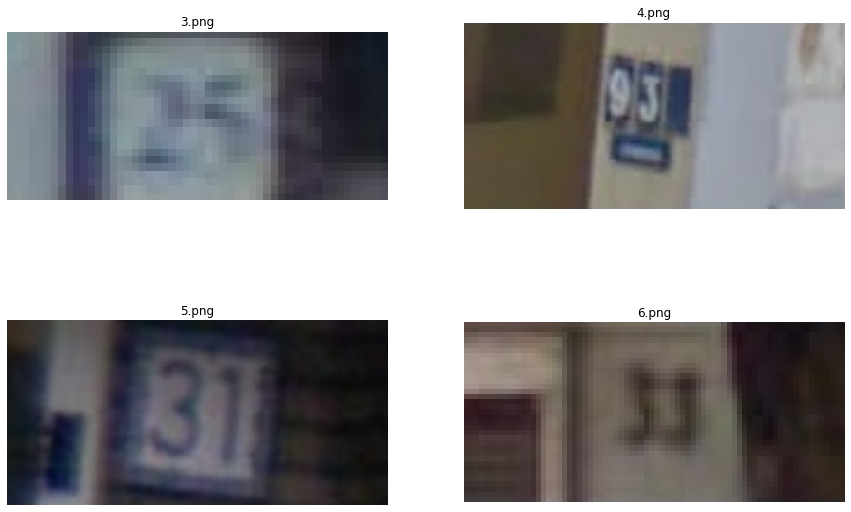

In [243]:
#Let's load 4 images to see if the function works.
#Load and display the images from 3.png to 6.png:

list_of_images, start = load_image('C:/Users/h/Desktop/train', 3, 6)

#Display the images with appropriate titles:
fig, ax = plt.subplots(2,2, figsize=(15,10))
plt.axis('off')
ax=ax.ravel()
for i in range(len(list_of_images)):
    ax[i].imshow(list_of_images[i])
    ax[i].axis('off')
    ax[i].set_title(f'{start+i}.png')

We need to read the coordinates and labels of the digits' bounding boxes. The following code reads them from the provided metadata. 

In [252]:
#Please note the code in this cell is taken from:
#https://stackoverflow.com/questions/41176258/h5py-access-data-in-datasets-in-svhn
#Creating the metadata for the boxes 
#surrounding the numbers for the training set:

f = h5py.File('digitStruct_train.mat')

metadata= {}
metadata['height'] = []
metadata['label'] = []
metadata['left'] = []
metadata['top'] = []
metadata['width'] = []

def print_attrs(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(int(obj[0][0]))
    else:
        for k in range(obj.shape[0]):
            vals.append(int(f[obj[k][0]][0][0]))
    metadata[name].append(vals)

for item in f['/digitStruct/bbox']:
    #print(f[item[0]])
    f[item[0]].visititems(print_attrs)



In [254]:
metadata['label'][:10]

[[1, 9],
 [2, 3],
 [2, 5],
 [9, 3],
 [3, 1],
 [3, 3],
 [2, 8],
 [7, 4, 4],
 [1, 2, 8],
 [1, 6]]

We obtained the data for the bounding boxes. Let's draw the boxes of the digits on an image to see if the coordinates are right. 

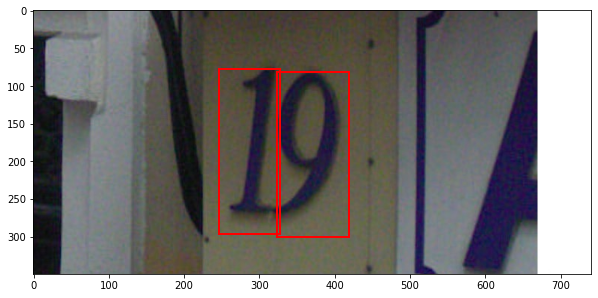

In [246]:
#Load an image
image, start = load_image('C:/Users/h/Desktop/train', 1, 1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image[0])
#Draw the boxes for the digits using patches.
for j in range(len(metadata['label'][0])):
    mint, minc, maxt, maxc = metadata['left'][0][j], metadata['top'][0][j],\
        metadata['width'][0][j], metadata['height'][0][j]
    rect =mpatches.Rectangle((mint, minc),maxt, maxc, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)


We will follow the same procedure for the test set. We will read box coordinate data from 'digitStruct_test.mat' file.

In [253]:
#Creating the metadata for the boxes 
#drawn around the numbers for the test set:

f_test = h5py.File('digitStruct_test.mat')

metadata_test= {}
metadata_test['height'] = []
metadata_test['label'] = []
metadata_test['left'] = []
metadata_test['top'] = []
metadata_test['width'] = []

def print_attrs_test(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(int(obj[0][0]))
    else:
        for k in range(obj.shape[0]):
            vals.append(int(f_test[obj[k][0]][0][0]))
    metadata_test[name].append(vals)

for item in f_test['/digitStruct/bbox']:
    #print(f[item[0]])
    f_test[item[0]].visititems(print_attrs_test)



Let's draw the boxes of the digits on an image.

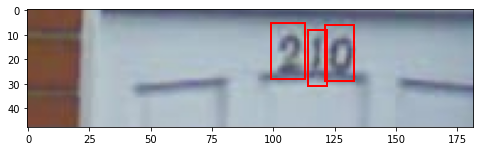

In [245]:
#Load an image from the test set and draw boxes around the digits:
image, start = load_image('C:/Users/h/Desktop/test', 1, 2)
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image[1])

for j in range(len(metadata_test['label'][1])):
        mint, minc, maxt, maxc = metadata_test['left'][1][j], metadata_test['top'][1][j],\
        metadata_test['width'][1][j], metadata_test['height'][1][j]
        rect =mpatches.Rectangle((mint, minc),maxt, maxc, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

The house numbers on the images consist of one or more digits and we are given the label value for each digit in the metadata. That means we need to extract digits from those images and save their data in a list, so that each label value will correspond to an entry in that list.
To extract the digits from the images, we will use the coordinates of the bounding boxes.
The following function will go through the provided train and test sets, and for each image in those sets, it will create a cut-out image of each digit and save it into an appropriate list. In the end, we will have two lists train_x and test_x, which will contain the cut-outs of digits  in the train and test sets respectively. 
As the function goes through the train and test sets, it will also extract the corresponding label value for each digit from the metadata and add it to train_y and test_y lists.
Please note, unfortunately, the bounding box height or width was zero for some digits in the images, so the function was written in a way to omit those cases.

In [9]:
#Creating digit cut-outs from the images 
#and capturing corresponding labels by using metadata:
def create_x_y(training_list,training_start, testing_list, testing_start):
    '''
        This function captures digit cut-outs from the images provided in train and test sets.
        It also saves corresponding label values for those digits.
        'training_start' and 'testing_start' inputs need to be provided so that the function can find 
        the corresponding metadata for the provided images.
        If for any digit, the bounding box's height or width is zero, that digit is omitted.
        The function saves digit cut-out images in train_x, and test_x lists and corresponding label
        values in train_y and test_y lists and finally returns these four lists.
        '''
    train_x = []
    train_y = []
    for i in range(len(training_list)):
        image = training_list[i]
        for j in range(len(metadata['label'][i+training_start-1])):
            cut_out = image[metadata['top'][i+training_start-1][j]:metadata['top'][i+training_start-1][j]+metadata['height'][i+training_start-1][j],\
                                metadata['left'][i+training_start-1][j]:metadata['left'][i+training_start-1][j]+metadata['width'][i+training_start-1][j],:] 
            if cut_out.shape[0] == 0 or cut_out.shape[1] == 0:
                continue
            else:
                train_x.append(cut_out)
                train_y.append(metadata['label'][i+training_start-1][j])
    test_x = []
    test_y = []
    for i in range(len(testing_list)):
        image = testing_list[i]
        for j in range(len(metadata_test['label'][i+testing_start-1])):
            cut_out = image[metadata_test['top'][i+testing_start-1][j]:metadata_test['top'][i+testing_start-1][j]+metadata_test['height'][i+testing_start-1][j],\
                                metadata_test['left'][i+testing_start-1][j]:metadata_test['left'][i+testing_start-1][j]+metadata_test['width'][i+testing_start-1][j],:] 
        
            if cut_out.shape[0] == 0 or cut_out.shape[1] == 0:
                continue
            else:
                test_x.append(cut_out)
                test_y.append(metadata_test['label'][i+testing_start-1][j])
    return train_x, train_y, test_x, test_y


We will use 10000 images for training, 3000 images for testing. Please note that each image will probably have more than one digit, so eventually the number of images (cut-outs) will be much more than these numbers.

In [247]:
#load the images
training_list,training_start = load_image('C:/Users/h/Desktop/train', 1, 10000)
testing_list,testing_start = load_image('C:/Users/h/Desktop/test',1, 3000)
#extract cut-outs of the digits in those images along with their corresponding label values
train_x_cut_out, train_y, test_x_cut_out, test_y = create_x_y(training_list,training_start, testing_list, testing_start)

Label 9
Shape of the cut-out:  (219, 96, 3)


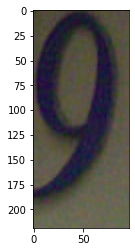

In [250]:
#See if the cut-out actually represents the number given in the target for the training set. 
plt.imshow(train_x_cut_out[1])
print("Label", train_y[1])
print("Shape of the cut-out: ", train_x_cut_out[1].shape)

Label 2
Shape of the cut-out:  (23, 14, 3)


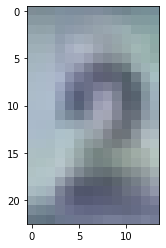

In [251]:
#See if the cut-out actually represents the number given in the target for the testing set. 
plt.imshow(test_x_cut_out[1])
print("Label", test_y[1])
print("Shape of the cut-out: ", test_x_cut_out[1].shape)

Now that we have a way of obtaining the cut-outs of digits, we need to bring all images to the same size (Goal: 28x28). Also, images have three channels, we will take the average value of these channels for each pixel and assign it to the corresponding pixel in the new image. The following function carries out this process:

In [15]:
def resize_images(image):
    #Get the average RGB value and assign it to the new image, so 3 channels is dropped to one channel
    new_image = np.zeros(shape = (image.shape[0], image.shape[1]))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            new_image[i,j] = np.mean(image[i,j,:])
    #All images will have the size of (28, 28)        
    new_image = resize(new_image[:,:], (28, 28))
    return new_image

(28, 28)


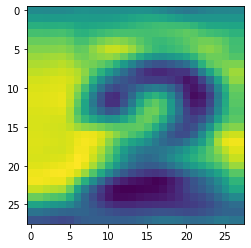

In [16]:
new = resize_images(test_x_cut_out[1])
plt.imshow(new)
print(new.shape)

In [17]:
#Apply resizing function to all images in the training and testing sets
train_x =[]
test_x = []
for i in train_x_cut_out:
    train_x.append(resize_images(i))
for i in test_x_cut_out:
    test_x.append(resize_images(i))

In [18]:
print("Number of images in the training set: ", len(train_x))
print("Number of images in the testing set: ", len(test_x))
print("Number of labels in the training set: ", len(train_y))
print("Number of labels in the testing set: ", len(test_y))

Number of images in the training set:  21997
Number of images in the testing set:  5956
Number of labels in the training set:  21997
Number of labels in the testing set:  5956


In [19]:
#Turn lists into numpy arrays
train_x = np.array(train_x)
test_x = np.array(test_x)
train_y = np.array(train_y)
test_y = np.array(test_y)

In [20]:
print(f'Input training data shape: {train_x.shape}')
print(f'Output training data shape: {train_y.shape}')
print(f'Input testing data shape: {test_x.shape}')
print(f'Output testing data shape: {test_y.shape}')

Input training data shape: (21997, 28, 28)
Output training data shape: (21997,)
Input testing data shape: (5956, 28, 28)
Output testing data shape: (5956,)


In [21]:
img_rows, img_cols = 28, 28

In [22]:
#Figure out in what shape the neural network accepts image data.
if K.image_data_format() == 'channels_first':
    train_x = train_x.reshape(train_x.shape[0], 1, img_rows, img_cols)
    test_x = test_x.reshape(test_x.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    train_x = train_x.reshape(train_x.shape[0], img_rows, img_cols, 1)
    test_x = test_x.reshape(test_x.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [23]:
print(f'New data shape: {input_shape}')

New data shape: (28, 28, 1)


We need to normalize the data so all the pixel values are in between 0 and 1. 

In [25]:
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x /= 255
test_x /= 255

In [259]:
train_x[0][0][:5]

array([[0.28985003],
       [0.28671733],
       [0.2839465 ],
       [0.2765122 ],
       [0.27140486]], dtype=float32)

In [248]:
#Number of output classes (0-9)
num_classes = 10

In [28]:
print(f'Output for entry 0: {train_y[0]}')

Output for entry 0: 1


In [29]:
#Zeros are represented by 10s in the dataset, convert them to zeros
for i in range(len(train_y)):
    if train_y[i] == 10:
        train_y[i] =0
for i in range(len(test_y)):
    if test_y[i] == 10:
        test_y[i] =0

In [30]:
#One-hot-coding both train and test labels
train_y = keras.utils.to_categorical(train_y, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)

In [31]:
print(f'New output for entry 0: {train_y[0]}')

New output for entry 0: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [32]:
print(f'New output data shape: {train_y.shape}')
print(f'New output data shape: {test_y.shape}')

New output data shape: (21997, 10)
New output data shape: (5956, 10)


In [177]:
#Setting the model with two convolution and two pooling layers. Activation function for the perceptrons are RELU function.
model = Sequential([ layers.Conv2D(32, (5, 5), input_shape=(img_cols, img_rows, 1)), 
                    layers.MaxPool2D(pool_size=(2, 2)), 
                    layers.Conv2D(64, (5, 5)), 
                    layers.MaxPool2D(pool_size=(2, 2)), 
                    layers.Flatten(), 
                    layers.Dense(1024, activation='relu'), 
                    layers.Dense(10, activation='softmax') ])

In [178]:
assert model.count_params() == 1111946

In [222]:
#Train the model
model.compile('rmsprop', 'categorical_crossentropy') 
model.fit(train_x, train_y, batch_size=64, epochs=512, validation_split=0.1, 
          callbacks=[keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)])

Epoch 1/512
310/310 [==============================] - 21s 64ms/step - loss: 0.1954 - val_loss: 0.7849
Epoch 2/512
310/310 [==============================] - 21s 68ms/step - loss: 0.1642 - val_loss: 0.9283
Epoch 3/512
310/310 [==============================] - 22s 71ms/step - loss: 0.1453 - val_loss: 0.9617
Epoch 4/512
310/310 [==============================] - 21s 68ms/step - loss: 0.1267 - val_loss: 0.9841
Epoch 5/512
310/310 [==============================] - 20s 64ms/step - loss: 0.1069 - val_loss: 1.1990


In [223]:
model.evaluate(test_x, test_y)

187/187 [==============================] - 2s 12ms/step - loss: 0.8919


0.8918677568435669

In [224]:
cnn_accuracy = accuracy_score((model.predict(test_x) > 0.5).astype("int32"), test_y)

187/187 [==============================] - 2s 9ms/step


In [225]:
cnn_accuracy

0.8245466756212223

In [227]:
#Using the model, make predictions for training and testing data
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

187/187 [==============================] - 2s 8ms/step


In [228]:
train_predict[:5]

array([[1.68238021e-03, 8.90486419e-01, 8.61418841e-04, 4.88893420e-06,
        4.45253588e-02, 1.14095009e-07, 5.74053629e-05, 6.18024878e-02,
        3.51021549e-06, 5.76085004e-04],
       [7.60271447e-04, 5.34677497e-07, 3.48644389e-05, 1.67682146e-07,
        8.42835216e-05, 4.23424780e-07, 7.80943452e-08, 8.90681913e-05,
        1.03214184e-07, 9.99030232e-01],
       [3.68149268e-22, 4.81505677e-13, 1.00000000e+00, 8.33411291e-12,
        6.59461770e-14, 1.30326085e-23, 5.23832772e-22, 1.04553085e-12,
        5.13644594e-09, 1.39243914e-18],
       [1.81358706e-10, 9.09839017e-14, 5.59656765e-09, 9.99875665e-01,
        6.81325352e-09, 1.93132776e-09, 7.11199762e-13, 7.14631804e-13,
        3.59027808e-07, 1.23920065e-04],
       [4.27972554e-04, 4.56046022e-04, 9.98584390e-01, 7.86824967e-05,
        2.23006980e-04, 2.87273991e-07, 2.31742324e-05, 3.44992054e-06,
        8.99669158e-06, 1.94019201e-04]], dtype=float32)

In [229]:
train_y[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

We need to get the highest value in each row which corresponds to the predicted number. Eg. If the highest number is found in the third place then the prediction is number 2 (arrays start from zero). The following function achieves that:

In [230]:
def assign_index(row):
    return row.argmax()
test_predictions = pd.DataFrame(test_predict).apply(assign_index, axis=1)
train_predictions = pd.DataFrame(train_predict).apply(assign_index, axis=1)


In [231]:
#Get dummies for the predictions, so they are in the same form as the target training and target testing:
train_predictions_dummied = pd.get_dummies(train_predictions)
test_predictions_dummied = pd.get_dummies(test_predictions)


In [232]:
test_predictions_dummied.head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [233]:
test_y[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

### Results:

In [234]:
#Print out the accuracies for training and testing sets and classification report
train_score = accuracy_score(train_y, train_predictions_dummied) * 100
print(f"Train accuracy score: {train_score:.2f}%")
test_score = accuracy_score(test_y, test_predictions_dummied) * 100
print(f"Test accuracy score: {test_score:.2f}%")
print(classification_report(test_y, test_predictions_dummied))

Train accuracy score: 94.71%
Test accuracy score: 83.51%
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       402
           1       0.91      0.85      0.88      1158
           2       0.88      0.86      0.87       913
           3       0.83      0.77      0.80       676
           4       0.83      0.88      0.85       593
           5       0.82      0.85      0.84       549
           6       0.78      0.79      0.79       467
           7       0.85      0.83      0.84       441
           8       0.83      0.77      0.80       383
           9       0.76      0.78      0.77       374

   micro avg       0.84      0.84      0.84      5956
   macro avg       0.82      0.83      0.82      5956
weighted avg       0.84      0.84      0.84      5956
 samples avg       0.84      0.84      0.84      5956



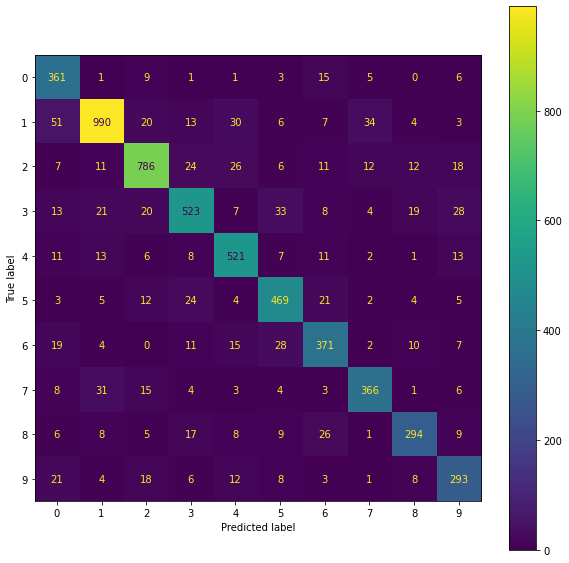

In [235]:
#print out the confusion matrix
conf_m = confusion_matrix(pd.DataFrame(test_y).apply(assign_index, axis=1), test_predictions)
conf_mat_d = ConfusionMatrixDisplay(conf_m)
fig, ax = plt.subplots(figsize=(10,10))
conf_mat_d.plot(ax=ax)

### Analysis:

We see that the training accuracy is almost 95% and the testing accuracy is close to 84% which is pretty good considering how washed-out some of the digits looked like. F1 score varies from 77% ('9's) to 88% ('1's).
Confusion matrix tells us the model was pretty good at predicting ones and twos. However, many ones were misclassified as sevens (34 of them) and vice versa. This is probably due to the similarity in their shapes. Nines were misclassified more frequently than any other numbers. We see that they were mixed up with zeros, twos and fours, may be due to how differently the loops looked like. Sixes were mostly confused with fives and eights, again probably due to their loops. 
In another project, I used KNN and SVM to classify these digits. The results, 65.2% with KNN and 66% with SVM, were nowhere near to these results obtained by the CNN which is understandable as CNNs take advantage of convolution, pooling and backpropagation.

Reference:
Dataset: [house numbers](http://ufldl.stanford.edu/housenumbers/)